### Imports 

In [18]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data loading 

##### Run the following cells to load the dataset. Setting download=True will download it for you.

In [3]:
cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=True, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', 
                                             train=False, 
                                             transform=None, 
                                             target_transform=None,
                                             download=True)

# Divides the dataset into train and val so that we can use the val to choose our hyperparameters
train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [40000, 10000], 
                                                           generator=torch.Generator().manual_seed(12345))
test_dataset = cifar10_test

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Helper code to support adding different transforms on the dataset lazily after downloading the dataset
# From https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/5
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]         
        return x, y

    def __len__(self):
        return len(self.dataset)

#### Standard transforms to apply on images - Convert to tensors and normalize with mean and std. These are the basic transforms that you will always apply. The mean and std have been pre calculated on the training set. 

In [5]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])

In [6]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [7]:
bs = 128
torch.backends.cudnn.benchmark = True
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False,num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=False,num_workers=10, pin_memory=True)

### Q 2.1 Training loop

In this question, fill in the missing parts to build a generic training loop that returns the train and validation losses and accuracies. The #TODOs will guide you through the key points and you should fill some code for each #TODO. You might need to add some additional code for bookkeeping the losses and accuracies

In [8]:
def train_loop(model, criterion, optimizer,  train_loader, val_loader, device):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0

    # Training
    for t in tqdm(range(50)):
        # TODO : Set the model to train mode        
        model.train()
        train_loss = 0
        correct = 0
        n = 0
        # TODO: Loop over the training set 
        for batch_idx, samples in enumerate(train_loader):
            # TODO: Put the inputs and targets on the write device
            image = samples[0].to(device)
            label = samples[1].to(device)
            # TODO: Feed forward to get the logits
            output = model(image)
            _, preds = torch.max(output, dim = 1)
            # TODO: Compute the loss and accuracy
            loss = criterion(output, label)
            # TODO: zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()
            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 
            loss.backward()
            # TODO: Update params
            optimizer.step()
            # TODO: Keep track of accuracy and loss
            train_loss += loss.item()
            n += image.shape[0]
            correct += torch.sum(preds == label).item()
        
        train_losses.append(train_loss / n)
        train_accuracies.append(correct / n)
        
        # TODO: Switch the model to eval mode
        model.eval()

        val_loss = 0
        val_correct = 0
        val_n = 0
        with torch.no_grad():
            # TODO: Loop over the validation set 
            for batch_idx, samples in enumerate(val_loader):
                # TODO: Put the inputs and targets on the write device
                image = samples[0].to(device)
                label = samples[1].to(device)
                # TODO: Feed forward to get the logits
                output = model(image)
                _, preds = torch.max(output, dim=1)
                # TODO: Compute the loss and accuracy
                loss = criterion(output, label)
                # TODO: Keep track of accuracy and loss
                val_loss += loss.item()
                val_n += image.shape[0]
                val_correct += torch.sum(preds == label).item()
            val_losses.append(val_loss / val_n)
            val_accuracies.append(val_correct / val_n)
                
        if val_accuracies[-1] > best_val:
            best_val = val_accuracies[-1]
            patience_counter = 0
            # TODO: Save best model, optimizer, epoch_number
            checkpoint = {
                'model':model.state_dict(),
                'epoch':t,
                'optimizer':optimizer.state_dict()
            }
            torch.save(checkpoint, 'checkpoint.pth')
            
        else:
            patience_counter += 1    
            if patience_counter > max_patience: 
                break

        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

    return train_losses, train_accuracies, val_losses, val_accuracies

### Q 2.2 Shallow convolutional network. 

In [9]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [10]:
ShallowNet =  nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=8),
      View((-1,256)),
      nn.Linear(256, 10),
)

#### Write the object oriented version of ShallowNet

In [11]:
class ShallowConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        """

        Parameters
        ----------
        input_channels : Number of input channels
        num_classes : Number of classes for the final prediction 
        """
        
        # TODO
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = input_channels, out_channels = 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=8),
            View((-1,256)),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        """

        Parameters
        ----------
        x

        Returns
        -------
        output : Result after running through the model
        """
        
        # TODO
        return self.model(x)
        

### Q2.3 Instantiate the model and run this using an SGD optimizer, with the appropriate loss function for classification

Report the learning curves (training and validation accuracy vs number of epochs)

In [12]:
# TODO : Initialize the model and cast to correct device
model = ShallowConvnet(input_channels=3, num_classes=10)
model.to(device)
# TODO : Initialize the criterion
criterion = nn.CrossEntropyLoss()
# TODO : Initialize the SGD optimizer with lr 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# TODO : Run the training loop using this model
loss_train, acc_train, loss_val, acc_val = train_loop(model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    device)

Text(0.5, 1.0, 'Shallow Loss')

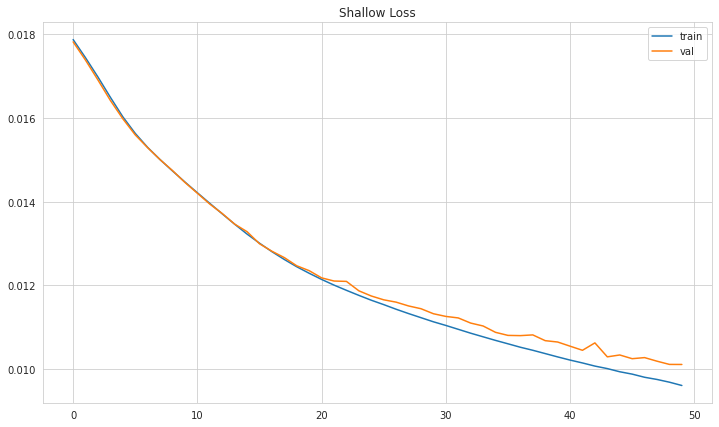

In [20]:
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val')
plt.legend()
plt.title('Shallow Loss')

Text(0.5, 1.0, 'Shallow acc')

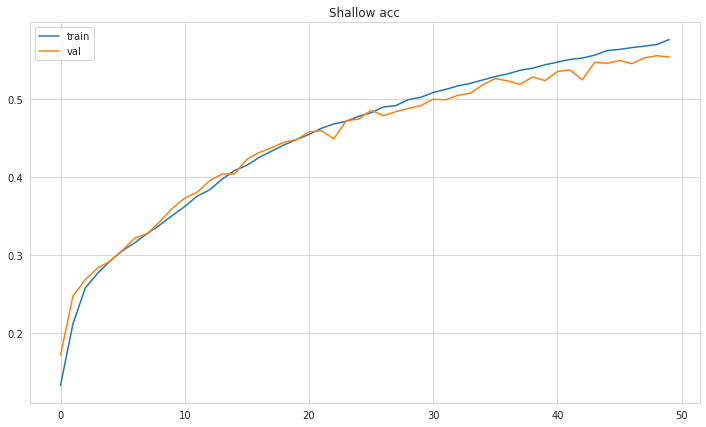

In [21]:
plt.plot(acc_train, label='train')
plt.plot(acc_val, label='val')
plt.legend()
plt.title('Shallow acc')

### Q2.4 Simple convolution network - 

Design a convolutional neural network with the following specification: 
For each convolution layer, use appropriate padding such that it maintains the resolution of the image. The resolution should be changing only when you introduce maxpooling layers. Each convolution layer should be followed by a relu non-linearity. The first two blocks containing 3 convolutional layers are each followed by a maxpooling layer that halves the resolution of the image. After the third block, use maxpooling to get a resolution of 1 X 1. Finally, apply a linear transformation to project to the number of classes. 

Structure of the convolution layers of the model:
1. Number of input channels to the model = 3
2. First convolution layer of kernel size 5 with filter size 64 and padding such that it maintains the resolution of the image.
3. Followed by a block of 3 convolution layers of kernel size 3, filter size 64 and padding such that it maintains the resolution of the image.
5. Followed by 3 convolution layers of kernel size 3, filter size 128 and padding such that it maintains the resolution of the image.
6. Followed by 3 convolution layers of kernel size 3, filter size 256 and padding such that it maintains the resolution of the image. 




In [14]:
# Use the description of the structure of the model and the hints given below 

class SimpleConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet, self).__init__()
        # TODO
        self.num_classes = num_classes
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, padding=2),
            nn.ReLU())
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.projection = nn.Sequential(
            nn.MaxPool2d(kernel_size=8),
            View((-1,256)),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        _ = self.conv(x)

        # HINT: block of 3 conv 
        _ = self.block1(_)

        # HINT : block of 3 conv 
        _ = self.block2(_)

        # HINT: block of 3 conv 
        _ = self.block3(_)

        # HINT: projection 
        output = self.projection(_)
        
        return output
        

In [26]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet(3, 10)
model.to(device)
# TODO : Initialize the criterion 
c = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
o = torch.optim.SGD(model.parameters(), lr=1e-3)
# TODO : Run the training loop using this model
l_t, a_t, l_v, a_v = train_loop(model, c, o, train_loader, val_loader, device)

[EPOCH]: 0, [TRAIN LOSS]: 0.018024, [TRAIN ACCURACY]: 0.100
[EPOCH]: 0, [VAL LOSS]: 0.018194, [VAL ACCURACY]: 0.101 

[EPOCH]: 1, [TRAIN LOSS]: 0.018024, [TRAIN ACCURACY]: 0.100
[EPOCH]: 1, [VAL LOSS]: 0.018194, [VAL ACCURACY]: 0.101 

[EPOCH]: 2, [TRAIN LOSS]: 0.018023, [TRAIN ACCURACY]: 0.100
[EPOCH]: 2, [VAL LOSS]: 0.018194, [VAL ACCURACY]: 0.101 

[EPOCH]: 3, [TRAIN LOSS]: 0.018023, [TRAIN ACCURACY]: 0.100
[EPOCH]: 3, [VAL LOSS]: 0.018193, [VAL ACCURACY]: 0.101 

[EPOCH]: 4, [TRAIN LOSS]: 0.018022, [TRAIN ACCURACY]: 0.100
[EPOCH]: 4, [VAL LOSS]: 0.018193, [VAL ACCURACY]: 0.101 

[EPOCH]: 5, [TRAIN LOSS]: 0.018022, [TRAIN ACCURACY]: 0.100
[EPOCH]: 5, [VAL LOSS]: 0.018193, [VAL ACCURACY]: 0.101 



### Q 2.5 Report results of training using SGD optimizer for both ShallowNet and SimpleConvnet. What do you observe?

Using the SGD optimizer for ShallowNet saw steady training improvements, but no training improvement using SimpleConvnet. It could be because the convnet is too deep, making it difficult to backpropagate the learning signal all the way back to the start of the layers.

### Q 2.6 Add batch normalization

#### Q2.6 a After each relu layer, add a batch normalization layer to the network SimpleConvnet you created above

In [24]:
class SimpleConvnet2(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleConvnet2, self).__init__()
        # TODO
        self.num_classes = num_classes
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64))
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=256)
        )
        self.projection = nn.Sequential(
            nn.MaxPool2d(kernel_size=8),
            View((-1,256)),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
       
        # TODO 

        # HINT: first conv layer 
        _ = self.conv(x)

        # HINT: block of 3 conv 
        _ = self.block1(_)

        # HINT : block of 3 conv 
        _ = self.block2(_)

        # HINT: block of 3 conv 
        _ = self.block3(_)

        # HINT: projection 
        output = self.projection(_)
        
        return output
        

In [27]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet2(3, 10)
model.to(device)
# TODO : Initialize the criterion 
c = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
o = torch.optim.SGD(model.parameters(), lr=1e-3)
# TODO : Run the training loop using this model
l_t2, a_t2, l_v2, a_v2 = train_loop(model, c, o, train_loader, val_loader, device)

[EPOCH]: 0, [TRAIN LOSS]: 0.014164, [TRAIN ACCURACY]: 0.349
[EPOCH]: 0, [VAL LOSS]: 0.011923, [VAL ACCURACY]: 0.452 

[EPOCH]: 1, [TRAIN LOSS]: 0.010836, [TRAIN ACCURACY]: 0.498
[EPOCH]: 1, [VAL LOSS]: 0.010578, [VAL ACCURACY]: 0.518 

[EPOCH]: 2, [TRAIN LOSS]: 0.009497, [TRAIN ACCURACY]: 0.570
[EPOCH]: 2, [VAL LOSS]: 0.010051, [VAL ACCURACY]: 0.546 

[EPOCH]: 3, [TRAIN LOSS]: 0.008548, [TRAIN ACCURACY]: 0.619
[EPOCH]: 3, [VAL LOSS]: 0.009563, [VAL ACCURACY]: 0.571 

[EPOCH]: 4, [TRAIN LOSS]: 0.007727, [TRAIN ACCURACY]: 0.662
[EPOCH]: 4, [VAL LOSS]: 0.009263, [VAL ACCURACY]: 0.586 

[EPOCH]: 5, [TRAIN LOSS]: 0.007002, [TRAIN ACCURACY]: 0.702
[EPOCH]: 5, [VAL LOSS]: 0.008923, [VAL ACCURACY]: 0.601 

[EPOCH]: 6, [TRAIN LOSS]: 0.006356, [TRAIN ACCURACY]: 0.736
[EPOCH]: 6, [VAL LOSS]: 0.008590, [VAL ACCURACY]: 0.616 

[EPOCH]: 7, [TRAIN LOSS]: 0.005763, [TRAIN ACCURACY]: 0.769
[EPOCH]: 7, [VAL LOSS]: 0.008547, [VAL ACCURACY]: 0.615 

[EPOCH]: 8, [TRAIN LOSS]: 0.005216, [TRAIN ACCURACY]: 0.

#### Q2.6 b Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) using SGD (lr 1e-3) with and without batch normalization. Comment on the difference. 

Without batchnorm, the training cannot get off the ground at all, and training is prematurely halted as soon as possible. For the convnet with batchnorm, large training improvements are made for the first 25 or so epochs. Validation performance peters out around the 12th epoch, but batchnorm performance far surpasses that of not having batchnorm.

Text(0.5, 1.0, 'Loss - with and without batchnorm')

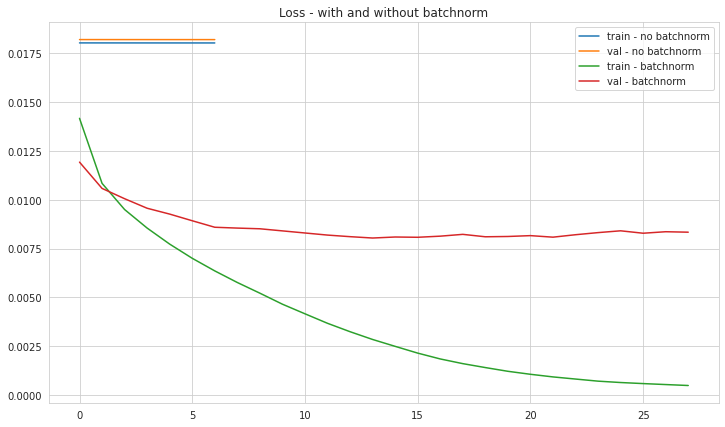

In [28]:
plt.plot(l_t, label='train - no batchnorm')
plt.plot(l_v, label='val - no batchnorm')
plt.plot(l_t2, label='train - batchnorm')
plt.plot(l_v2, label='val - batchnorm')
plt.legend()
plt.title('Loss - with and without batchnorm')

Text(0.5, 1.0, 'Accuracy - with and without batchnorm')

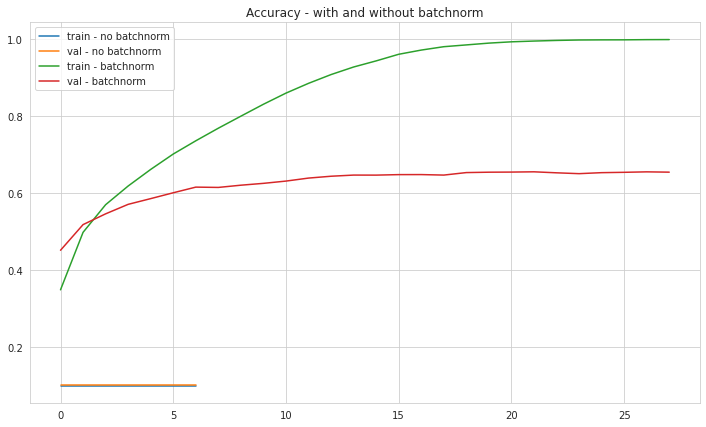

In [29]:
plt.plot(a_t, label='train - no batchnorm')
plt.plot(a_v, label='val - no batchnorm')
plt.plot(a_t2, label='train - batchnorm')
plt.plot(a_v2, label='val - batchnorm')
plt.legend()
plt.title('Accuracy - with and without batchnorm')

#### Q2.6 c. Try running the same two networks with an Adam optimizer (lr 1e-4). Plot the the training curves (training loss vs \# epochs, training accuracy vs # epochs) with and without batch normalization. Comment on the difference. 

In [30]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet(3, 10)
model.to(device)
# TODO : Initialize the criterion 
c = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
o = torch.optim.Adam(model.parameters(), lr=1e-4)
# TODO : Run the training loop using this model
l_t, a_t, l_v, a_v = train_loop(model, c, o, train_loader, val_loader, device)

[EPOCH]: 0, [TRAIN LOSS]: 0.014976, [TRAIN ACCURACY]: 0.295
[EPOCH]: 0, [VAL LOSS]: 0.013018, [VAL ACCURACY]: 0.399 

[EPOCH]: 1, [TRAIN LOSS]: 0.012019, [TRAIN ACCURACY]: 0.442
[EPOCH]: 1, [VAL LOSS]: 0.011231, [VAL ACCURACY]: 0.486 

[EPOCH]: 2, [TRAIN LOSS]: 0.010687, [TRAIN ACCURACY]: 0.511
[EPOCH]: 2, [VAL LOSS]: 0.010468, [VAL ACCURACY]: 0.530 

[EPOCH]: 3, [TRAIN LOSS]: 0.009683, [TRAIN ACCURACY]: 0.560
[EPOCH]: 3, [VAL LOSS]: 0.009555, [VAL ACCURACY]: 0.568 

[EPOCH]: 4, [TRAIN LOSS]: 0.008713, [TRAIN ACCURACY]: 0.604
[EPOCH]: 4, [VAL LOSS]: 0.009129, [VAL ACCURACY]: 0.597 

[EPOCH]: 5, [TRAIN LOSS]: 0.008019, [TRAIN ACCURACY]: 0.640
[EPOCH]: 5, [VAL LOSS]: 0.009465, [VAL ACCURACY]: 0.575 

[EPOCH]: 6, [TRAIN LOSS]: 0.007325, [TRAIN ACCURACY]: 0.674
[EPOCH]: 6, [VAL LOSS]: 0.008565, [VAL ACCURACY]: 0.626 

[EPOCH]: 7, [TRAIN LOSS]: 0.006655, [TRAIN ACCURACY]: 0.705
[EPOCH]: 7, [VAL LOSS]: 0.008238, [VAL ACCURACY]: 0.640 

[EPOCH]: 8, [TRAIN LOSS]: 0.006007, [TRAIN ACCURACY]: 0.

In [31]:
# TODO : Initialize the model and cast to correct device
model = SimpleConvnet2(3, 10)
model.to(device)
# TODO : Initialize the criterion 
c = nn.CrossEntropyLoss()
# TODO : Initialize the optimizer 
o = torch.optim.Adam(model.parameters(), lr=1e-4)
# TODO : Run the training loop using this model
l_t2, a_t2, l_v2, a_v2 = train_loop(model, c, o, train_loader, val_loader, device)

[EPOCH]: 0, [TRAIN LOSS]: 0.011376, [TRAIN ACCURACY]: 0.484
[EPOCH]: 0, [VAL LOSS]: 0.009303, [VAL ACCURACY]: 0.586 

[EPOCH]: 1, [TRAIN LOSS]: 0.007668, [TRAIN ACCURACY]: 0.655
[EPOCH]: 1, [VAL LOSS]: 0.007491, [VAL ACCURACY]: 0.662 

[EPOCH]: 2, [TRAIN LOSS]: 0.005812, [TRAIN ACCURACY]: 0.748
[EPOCH]: 2, [VAL LOSS]: 0.006717, [VAL ACCURACY]: 0.707 

[EPOCH]: 3, [TRAIN LOSS]: 0.004371, [TRAIN ACCURACY]: 0.816
[EPOCH]: 3, [VAL LOSS]: 0.006309, [VAL ACCURACY]: 0.723 

[EPOCH]: 4, [TRAIN LOSS]: 0.003168, [TRAIN ACCURACY]: 0.876
[EPOCH]: 4, [VAL LOSS]: 0.005990, [VAL ACCURACY]: 0.736 

[EPOCH]: 5, [TRAIN LOSS]: 0.002053, [TRAIN ACCURACY]: 0.931
[EPOCH]: 5, [VAL LOSS]: 0.005933, [VAL ACCURACY]: 0.744 

[EPOCH]: 6, [TRAIN LOSS]: 0.001220, [TRAIN ACCURACY]: 0.967
[EPOCH]: 6, [VAL LOSS]: 0.005866, [VAL ACCURACY]: 0.757 

[EPOCH]: 7, [TRAIN LOSS]: 0.000528, [TRAIN ACCURACY]: 0.991
[EPOCH]: 7, [VAL LOSS]: 0.006446, [VAL ACCURACY]: 0.747 

[EPOCH]: 8, [TRAIN LOSS]: 0.000267, [TRAIN ACCURACY]: 0.

Text(0.5, 1.0, 'Loss - with and without batchnorm')

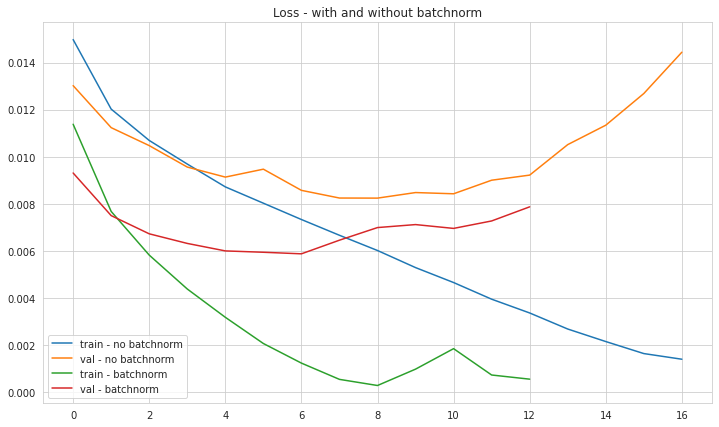

In [32]:
plt.plot(l_t, label='train - no batchnorm')
plt.plot(l_v, label='val - no batchnorm')
plt.plot(l_t2, label='train - batchnorm')
plt.plot(l_v2, label='val - batchnorm')
plt.legend()
plt.title('Loss - with and without batchnorm')

Text(0.5, 1.0, 'Accuracy - with and without batchnorm')

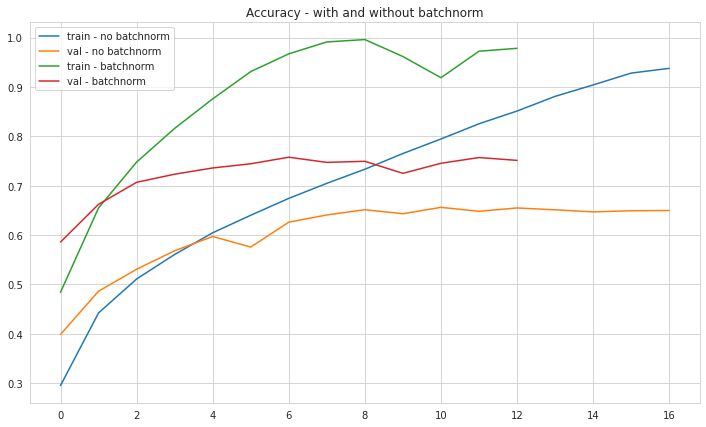

In [33]:
plt.plot(a_t, label='train - no batchnorm')
plt.plot(a_v, label='val - no batchnorm')
plt.plot(a_t2, label='train - batchnorm')
plt.plot(a_v2, label='val - batchnorm')
plt.legend()
plt.title('Accuracy - with and without batchnorm')

#### Q2.6 d Once you choose an optimizer and see that it does train, make sure your model has enough capacity by overfitting on one batch of the data set. You should be able to get 100% train accuracy. 


In [39]:
model = SimpleConvnet2(input_channels=3,
                       num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model.to(device)
model.train()

train_losses = []
train_accuracies = []

samples = next(iter(train_loader))
image = samples[0].to(device)
label = samples[1].to(device)
for t in tqdm(range(50)):
    train_loss = 0
    correct = 0
    n = 0
    # TODO: Feed forward to get the logits
    output = model(image)
    _, preds = torch.max(output, dim = 1)
    # TODO: Compute the loss and accuracy
    loss = criterion(output, label)
    # TODO: zero the gradients before running
    # the backward pass.
    o.zero_grad()
    # TODO: Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    # TODO: Update params
    optimizer.step()
    train_loss += loss.item()
    n += image.shape[0]
    correct += torch.sum(preds == label).item()

    train_losses.append(train_loss / n)
    train_accuracies.append(correct / n)
    print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))

[EPOCH]: 0, [TRAIN LOSS]: 0.037479, [TRAIN ACCURACY]: 0.109
[EPOCH]: 1, [TRAIN LOSS]: 0.024532, [TRAIN ACCURACY]: 0.211
[EPOCH]: 2, [TRAIN LOSS]: 0.016678, [TRAIN ACCURACY]: 0.375
[EPOCH]: 3, [TRAIN LOSS]: 0.012390, [TRAIN ACCURACY]: 0.555
[EPOCH]: 4, [TRAIN LOSS]: 0.010439, [TRAIN ACCURACY]: 0.672
[EPOCH]: 5, [TRAIN LOSS]: 0.010728, [TRAIN ACCURACY]: 0.688
[EPOCH]: 6, [TRAIN LOSS]: 0.011433, [TRAIN ACCURACY]: 0.664
[EPOCH]: 7, [TRAIN LOSS]: 0.012457, [TRAIN ACCURACY]: 0.602
[EPOCH]: 8, [TRAIN LOSS]: 0.011635, [TRAIN ACCURACY]: 0.609
[EPOCH]: 9, [TRAIN LOSS]: 0.008909, [TRAIN ACCURACY]: 0.750
[EPOCH]: 10, [TRAIN LOSS]: 0.005856, [TRAIN ACCURACY]: 0.875
[EPOCH]: 11, [TRAIN LOSS]: 0.003596, [TRAIN ACCURACY]: 0.906
[EPOCH]: 12, [TRAIN LOSS]: 0.002176, [TRAIN ACCURACY]: 0.945
[EPOCH]: 13, [TRAIN LOSS]: 0.001580, [TRAIN ACCURACY]: 0.992
[EPOCH]: 14, [TRAIN LOSS]: 0.001431, [TRAIN ACCURACY]: 1.000
[EPOCH]: 15, [TRAIN LOSS]: 0.001440, [TRAIN ACCURACY]: 0.992
[EPOCH]: 16, [TRAIN LOSS]: 0.00152

### Q 2.7 Add residual connections

#### Residual connections help stabilise training and lead to faster convergence. In this question you will introduce residual connections into the SimpleConvnet2 model that you built above. 

We will add residual connections after each block of 3 convolutional layers. Lets consider the first block of three convolutional layers. The input to this block, the so called residual, is added to the output of the block before the final batch normalization layer of that block. 


IMP NOTE: You will notice that the number of filters of these two summands are not the same. For this, you will need to use a convolution layer on the residual component, which changes the number of filters while keeping the rest of the dimensions the same. This can be achieved with a careful selection of the input_channels, output_channels, kernel_size and padding parameters. 

In [ ]:
class ResidualConvnet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResidualConvnet, self).__init__()
        
        # TODO
    
    def forward(self, x):
        
        # TODO 
        return output
        

In [ ]:
# TODO : Initialize the model and cast to correct device

# TODO : Initialize the criterion 

# TODO : Initialize the optimizer 

# TODO : Run the training loop using this model

### Q 2.8 Plot the training curves with and without the residual connection. Comment on the difference. 

### Q2.9 Reducing overfiting 



In the previous questions, you might have observed that there is a large difference between the training and validation losses. This is a sign that the model is overfitting. One way to combat this is by adding random transformations to the input data to make your model more robust and prevent it from memorizing the input data. 

Torchvision provides several transforms that you can readily apply to your data. Experiment with adding a few transforms and report your results in terms of learning curves to see if the gap between the training and validation loss reduces and try to achieve better perfomance on the validation set. 

In [ ]:
test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         [0.4373, 0.4434, 0.4725],
                                         [0.1201, 0.1231, 0.1052])
                                     ])

train_transform = transforms.Compose([
                                      # TODO: Add more transforms here 
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.4373, 0.4434, 0.4725],
                                          [0.1201, 0.1231, 0.1052])
                                      ])


In [ ]:
train_dataset_w_transform  = MapDataset(train_dataset, train_transform)
val_dataset_w_transform = MapDataset(val_dataset, test_transform)
test_dataset_w_transform = MapDataset(test_dataset, test_transform)

In [ ]:
bs = 128
train_loader = DataLoader(train_dataset_w_transform, batch_size=bs, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset_w_transform, batch_size=bs, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, drop_last=False)

#### Use the residual network that you built above and use data augmentation to reduce the overfitting 

In [ ]:
# TODO : Initialize the model and cast to correct device

# TODO : Initialize the criterion 

# TODO : Initialize the optimizer 

# TODO : Run the training loop using this model

### Q 2.10  Effect of learning rate decay 

#### Here you need to change the training loop to have one additional operation - add the scheduler step at the end of each epoch. Experiment with different learning rate schedulers provided by pytorch. Report results using atleast StepLR. 

In [ ]:
from torch.optim.lr_scheduler import StepLR

In [ ]:
def train_loop2(model, criterion, optimizer, scheduler,  train_loader, val_loader):
    """
    Generic training loop

    Parameters
    ----------
    model : Object instance of your model class 
    criterion : Loss function 
    optimizer : Instance of optimizer class of your choice 
    scheduler : Instance of scheduler class of your choice 
    train_loader : Training data loader 
    val_loader : Validation data loader

    Returns
    -------
    train_losses : List with train loss on dataset per epoch
    train_accuracies : List with train accuracy on dataset per epoch
    val_losses : List with validation loss on dataset per epoch
    val_accuracies : List with validation accuracy on dataset per epoch

    """
    best_val = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    max_patience = 5
    patience_counter = 0

    # Training
    for t in tqdm(range(50)):

        # TODO : Set the model to train mode        

        # TODO: Loop over the training set 

            # TODO: Put the inputs and targets on the write device
            
            # TODO: Feed forward to get the logits

            # TODO: Compute the loss and accuracy

            # TODO: zero the gradients before running
            # the backward pass.

            # TODO: Backward pass to compute the gradient
            # of loss w.r.t our learnable params. 

            # TODO: Update params
            
            # TODO: Keep track of accuracy and loss

        
        # Switch the model to eval mode
        # TODO


        with torch.no_grad():
            # TODO: Loop over the validation set 
            
                # TODO: Put the inputs and targets on the write device
            
                # TODO: Feed forward to get the logits

                # TODO: Compute the loss and accuracy

                # TODO: Keep track of accuracy and loss

        if val_accuracies[-1] > best_val:
          best_val = val_accuracies[-1]
          patience_counter = 0

          # TODO: Save best model, optimizer, epoch_number
          
        else:
          patience_counter += 1    
          
          if patience_counter > max_patience: 
            break

        print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACCURACY]: %.3f" % (t, train_losses[-1], train_accuracies[-1]))
        print("[EPOCH]: %i, [VAL LOSS]: %.6f, [VAL ACCURACY]: %.3f \n" % (t, val_losses[-1] ,val_accuracies[-1]))

        # TODO : scheduler step

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# TODO : Initialize the model and cast to correct device

# TODO : Initialize the criterion 

# TODO : Initialize the optimizer 

# TODO : Initialize the 

# TODO : Run the training loop using this model

### Q2.11 Hyper parameter tuning 


#### Experiment with a range of learning rates and optimizers, as well as the parameter in the learning rate scheduler for StepLR. Report the following plots: 

1. Learning curves (training and validation loss for 5 different learning rate with SGD optimizer)
2. Learning curves (training and validation loss for 5 different learning rate with Adam optimizer)
3. Learning curves (training and validation loss for 5 different gamma parameter for the StepLR)





### Q2.12 Load the model that gave you best validation accuracy and report results on the test set. 